In [2]:
import requests
import pickle
from Data.NHLPlayByPlay import NHLPlayByPlay
from tqdm import tqdm

In [2]:
# not working get data in this way.

In [3]:
import os
from threading import local
#Defines the seasons and game types we want to download
seasons = ['2018','2019','2020']
gameTypes  = ['01','02','03']
localdir = os.getcwd() + '/visual'
print(localdir)
# if localdir:
#     for s in seasons:
#         for t in gameTypes:
#             data = NHLPlayByPlay(season=s,GameType=t, localdir=localdir)

/Users/boweike/Desktop/UdeM/IFT6758/IFT6758-Project/visual


In [53]:
if localdir:
    s='2018'
    for t in gameTypes:
        NHLPlayByPlay(season=s,GameType=t, localdir=localdir)

Loaded 110 Games stored in local drive /Users/boweike/Desktop/UdeM/IFT6758/IFT6758-Project/visual/201801.pkl
Downloaded 0 games and saved them to local cache in /Users/boweike/Desktop/UdeM/IFT6758/IFT6758-Project/visual/201802.pkl
Downloaded 0 games and saved them to local cache in /Users/boweike/Desktop/UdeM/IFT6758/IFT6758-Project/visual/201803.pkl


In [10]:
# if localdir:
#     s='2019'
#     for t in gameTypes:
#         NHLPlayByPlay(season=s,GameType=t, localdir=localdir)

In [11]:
# if localdir:
#     s='2020'
#     for t in gameTypes:
#         NHLPlayByPlay(season=s,GameType=t, localdir=localdir)

In [197]:
game_data = []
year = ['2018','2019','2020']
season_type = ['01','02']
#1271 for seasons with 31 teams after year 2017 
max_game_id = 1272

In [4]:
def get_data(year):
    game_data = []
    season = '02'
    #1271 for seasons with 31 teams after year 2017 
    max_game_id = 1272
    for i in tqdm(range(0,max_game_id)): 
        r = requests.get(url=' http://statsapi.web.nhl.com/api/v1/game/'
             + year + season +str(i).zfill(4)+'/feed/live')
        data = r.json() 
        game_data.append(data)
    return game_data

In [5]:
data_18 = get_data('2018')

100%|███████████████████████████████████████| 1272/1272 [02:35<00:00,  8.18it/s]


In [6]:
print(len(data_18))

1272


In [8]:
with open('201802'+'.pkl', 'wb') as f:
    pickle.dump(data_18, f, pickle.HIGHEST_PROTOCOL)

In [9]:
#do same for 2019 and 2020 season
data_19 = get_data('2019')
data_20 = get_data('2020')

100%|███████████████████████████████████████| 1272/1272 [02:27<00:00,  8.65it/s]


In [10]:
with open('201902'+'.pkl', 'wb') as f:
    pickle.dump(data_19, f, pickle.HIGHEST_PROTOCOL)

with open('202002'+'.pkl', 'wb') as f:
    pickle.dump(data_20, f, pickle.HIGHEST_PROTOCOL)

In [11]:
print(len(data_19),len(data_20))

1272 1272


In [22]:
#game_data['2018020001']['liveData']['plays']['allPlays']

In [18]:
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
# Needed for custom colour mapping!
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
%matplotlib inline

In [25]:
#Q2

In [19]:
#define the corrdinate for goal and shoot
def get_shot_goal_data(game_data):
    
    #return league_data with info below
    league_data = {}
    league_data['Shot'] = {}
    league_data['Shot']['x'] = []
    league_data['Shot']['y'] = []
    league_data['Goal'] = {}
    league_data['Goal']['x'] = []
    league_data['Goal']['y'] = []
    event_types = ['Shot','Goal']

    for data in game_data:
    #iter game_data(dic) when use NHLPlayByPlay.py  
    #for data in game_data.values():
        if 'liveData' not in data:
            continue
        allplays = data['liveData']['plays']['allPlays'] 
        for play in allplays:       
            for event in event_types: 
                # If the play contains one of the events
                if play['result']['event'] in [event]:  
                    # Note not all coordinates contains x and y so must check both!
                    if 'x' in play['coordinates'] and 'y' in play['coordinates']:
                        league_data[event]['x'].append(play['coordinates']['x'])
                        league_data[event]['y'].append(play['coordinates']['y'])
    print(len(league_data['Goal']['x']),len(league_data['Goal']['y']))
    return league_data

In [23]:
def data_flip(league_data):
    # Concatenate the arrays for x and y league data
    x_all_shots = league_data['Shot']['x'] + league_data['Goal']['x'];
    y_all_shots = league_data['Shot']['y'] + league_data['Goal']['y']

    # flip the coordinates when necessary(i.e. (x or y) <0)
    # initial normalized list
    x_all_shots_norm = []
    y_all_shots_norm = []

    # Enumerate the list 
    for i,s in enumerate(x_all_shots):
        if x_all_shots[i] <0:
            x_all_shots_norm.append(-x_all_shots[i])
            y_all_shots_norm.append(-y_all_shots[i])
        else:
            x_all_shots_norm.append(x_all_shots[i])
            y_all_shots_norm.append(y_all_shots[i])

    # Do the same for goal
    x_goal_norm = []
    y_goal_norm = []
    for i,s in enumerate(league_data['Goal']['x']):
        if league_data['Goal']['x'][i] < 0:
            x_goal_norm.append(-league_data['Goal']['x'][i])
            y_goal_norm.append(-league_data['Goal']['y'][i])
        else:
            x_goal_norm.append(league_data['Goal']['x'][i])
            y_goal_norm.append(league_data['Goal']['y'][i])
    return [x_all_shots_norm, y_all_shots_norm, x_goal_norm, y_goal_norm]


In [49]:
def data_plot(year, shot_goal_xy):#figure plot prepare 
    x_all_shots_norm = shot_goal_xy[0]
    y_all_shots_norm = shot_goal_xy[1]
    x_goal_norm = shot_goal_xy[2]
    y_goal_norm = shot_goal_xy[3]
    
    #To keep the aspect ration correct we use a square figure size
    
    xbnds = np.array([-100,100])
    ybnds = np.array([-100,100])
    extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
    # set unit increments size  
    gridsize = 50
    mincnt = 0
    
    #it's ok to see empty figure just for test!(alpha = 0)
    #hexbin function
    hex_data = plt.hexbin(x_all_shots_norm, y_all_shots_norm,gridsize=gridsize, extent=extent,mincnt=mincnt,alpha = 0)
    # get the bin coordinates and counts
    bin_point = hex_data.get_offsets()
    shot_count = hex_data.get_array()

    # Do the same for goal data
    goal_hex_data =  plt.hexbin(x_goal_norm, y_goal_norm,gridsize=gridsize, extent=extent,mincnt=mincnt,alpha= 0)
    bin_point = goal_hex_data.get_offsets()
    goal_count = goal_hex_data.get_array()    


    # Using matplotlib create a new figure for plotting
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # Clean up the figure to be completely blank
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    fig.patch.set_alpha(0.0)

    # Remove the labelling of axes
    ax.set_xticklabels(labels = [''])
    ax.set_yticklabels(labels = [''])
    # Using pillow to get the rink image and extract the image size
    I = Image.open('map.png')
    ax.imshow(I);width, height = I.size

    # Calculate the scaling factor and offset (trial and error)
    scalingx = width/100 - 0.6;
    scalingy = height/100 + 0.5;
    x_trans = 33;
    y_trans = height/2

    # Scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
    S = 2.5*scalingx;

    for i,v in enumerate(bin_point):

        # Ignore empty locations
        if shot_count[i] < 3:
            continue
        # Normalize shot frequency data 
        shot_freq = shot_count[i] / max(shot_count)

        # Scale the hexagon size based on shot frequency
        radius = S*math.sqrt(shot_freq)
        #set shot red
        shot_color = '#FF0000'
        #plot the hexagon
        hex = RegularPolygon((x_trans+v[0]*scalingx, y_trans-v[1]*scalingy),\
                             numVertices=6, radius=radius, orientation=np.radians(0),
                             facecolor=shot_color, alpha=0.2, edgecolor=None)
        ax.add_patch(hex)

    #do same for goal
    for i,v in enumerate(bin_point):
        # Ignore empty locations
        if goal_count[i] < 1:
            continue
        # Normalize goal frequency data 
        goal_freq = goal_count[i] / max(goal_count)

        # Scale the hexagon size based on goal frequency
        radius = S*math.sqrt(goal_freq)
        #set goal green
        goal_color = '#008000'
        # plot the hexagon
        hex = RegularPolygon((x_trans+v[0]*scalingx, y_trans-v[1]*scalingy),\
                             numVertices=6, radius=radius, orientation=np.radians(0), \
                             facecolor=goal_color, alpha=0.8, edgecolor=None)
        ax.add_patch(hex)
    p_title = 'Season {}-{} shot(red)-goal(green) map'.format(year,year+1)
    plt.title(p_title)

In [30]:
with open('201802.pkl', 'rb') as f:
    game_data = pickle.load(f)
shot_goal_18 = get_shot_goal_data(game_data)
shot_goal_fliped_18 = data_flip(shot_goal_18)

7762 7762


/var/folders/ft/95p82c5j2zqgwg_m_l8hj7jc0000gn/T/ipykernel_94803/3216153463.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = [''])
/var/folders/ft/95p82c5j2zqgwg_m_l8hj7jc0000gn/T/ipykernel_94803/3216153463.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = [''])


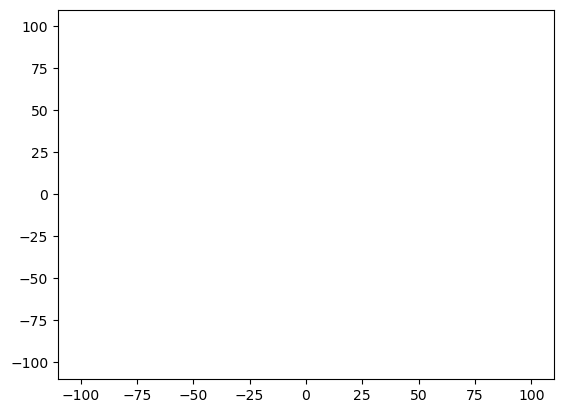

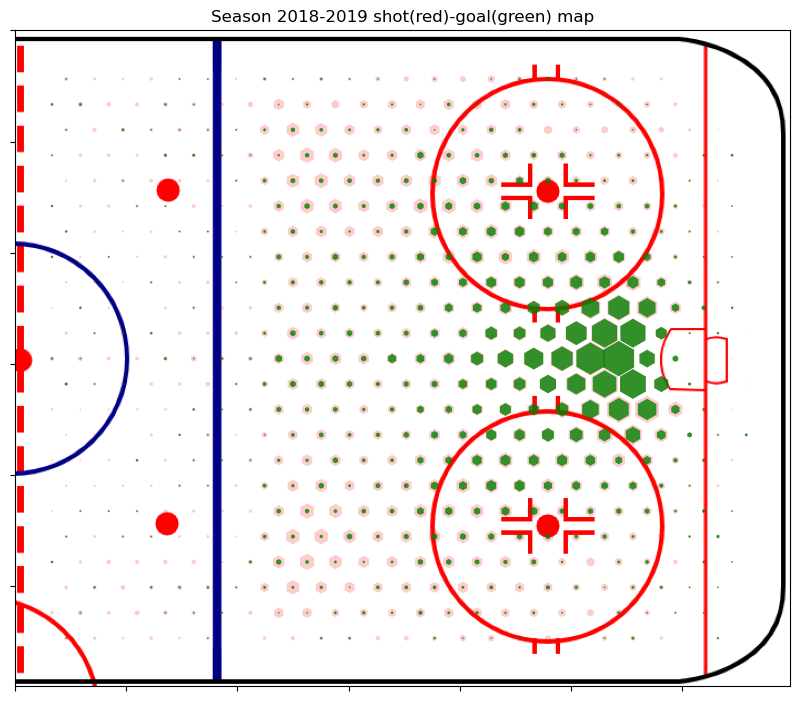

In [50]:
data_plot(2018, shot_goal_fliped_18)

6648 6648


/var/folders/ft/95p82c5j2zqgwg_m_l8hj7jc0000gn/T/ipykernel_94803/3216153463.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = [''])
/var/folders/ft/95p82c5j2zqgwg_m_l8hj7jc0000gn/T/ipykernel_94803/3216153463.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = [''])


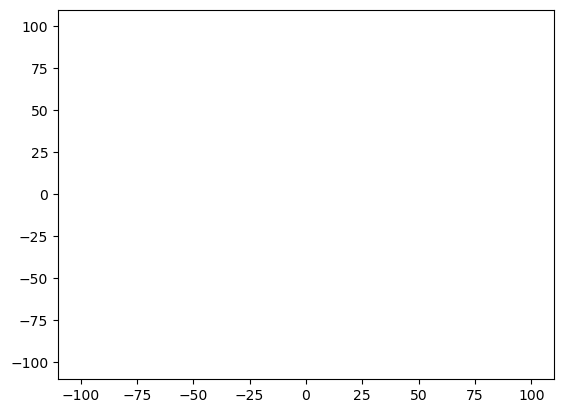

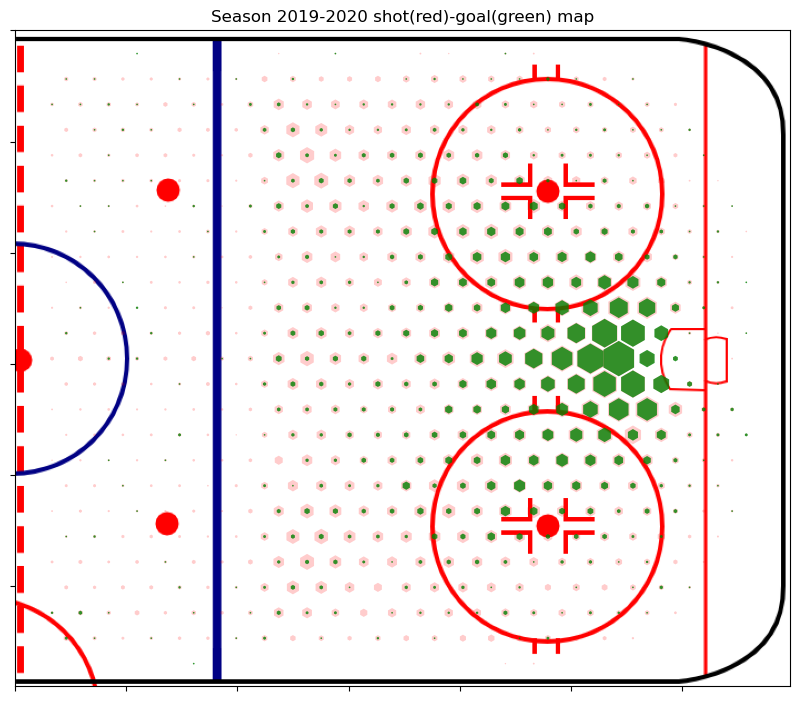

In [51]:
with open('201902.pkl', 'rb') as f:
    game_data = pickle.load(f)
shot_goal_19 = get_shot_goal_data(game_data)
shot_goal_fliped_19 = data_flip(shot_goal_19)
data_plot(2019, shot_goal_fliped_19)

5176 5176


/var/folders/ft/95p82c5j2zqgwg_m_l8hj7jc0000gn/T/ipykernel_94803/3216153463.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = [''])
/var/folders/ft/95p82c5j2zqgwg_m_l8hj7jc0000gn/T/ipykernel_94803/3216153463.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = [''])


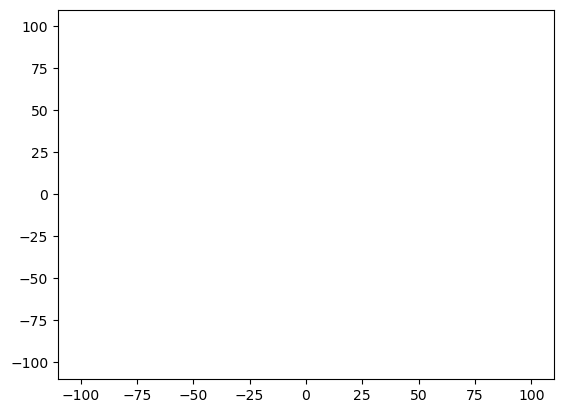

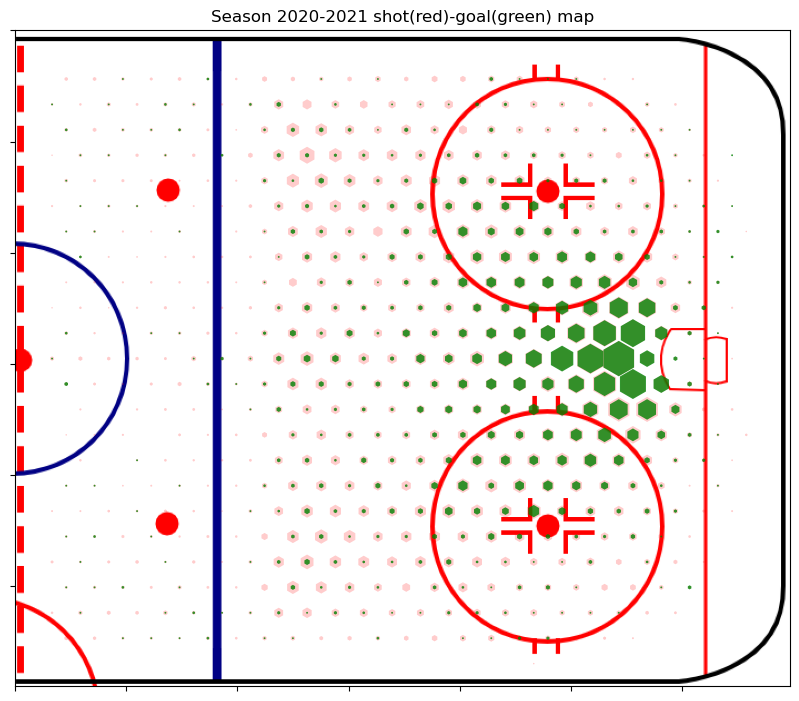

In [52]:
with open('202002.pkl', 'rb') as f:
    game_data = pickle.load(f)
shot_goal_20 = get_shot_goal_data(game_data)
shot_goal_fliped_20 = data_flip(shot_goal_20)
data_plot(2020, shot_goal_fliped_20)